In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import sys 
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
sys.path.insert(0, "../src")
import severson_data
import models
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [5]:
colours = ['#208F90', '#8F2317','#17608F','#8F5F17','#f2f3f4','#E56399','#DE6E4B']
golden_ratio =1.618

sns.set_palette(sns.color_palette(colours))


colors = cycler('color',
                colours)
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True, prop_cycle=colors)

In [6]:
config = configparser.ConfigParser()
config.read('../config.ini');
result_path =config['PATHS']['result_path'] 

In [7]:
model_path  = '../models/final_models/'
fig_path =config['PATHS']['figure_path'] 
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [8]:
results_all = pd.concat(results_list, axis=1).T.infer_objects()

results_all.experiment_name.unique()


array(['NumBatteries', 'NumCycles', 'NoCovariate', 'TransferModel'],
      dtype=object)

In [9]:
my_sue = 'NoCovariate'
results = results_all[results_all.experiment_name == my_sue]
results = results.reset_index()

my_results = None

if results.experiment_name[0] == my_sue:

    my_results = results[[
         'sequence_length', 'best_val_loss',
         'rmse_state_val', 'rmse_state_test', 'dropout' 
          ]].groupby([ 'sequence_length', 'dropout' ]).mean()
    


my_results

,,best_val_loss,rmse_state_val,rmse_state_test
sequence_length,dropout,,,
100,0.00,-1.21,364.22,541.05


In [10]:
best_model_idx = results.rmse_state_val.argmin()
seq_length = int(results.sequence_length[best_model_idx])
start_cycle = results.start[best_model_idx]



hidden_size = results.hidden_size[best_model_idx]

# load data

In [12]:
if 'data_dict' not in locals(): # just takes a lot of time
    data_path = config['DATASET']['severson_path'] 
    bat_dicts = severson_data.load_data_single(data_path)
data_dict = {**bat_dicts[0], **bat_dicts[1], }
# data_dict = {**bat_dicts[0], **bat_dicts[1], **bat_dicts[2],}

x, y, c, var  = severson_data.get_capacity_input(data_dict, num_offset=0, start_cycle = start_cycle, stop_cycle = 100)

x_scaled  = severson_data.scale_x(x,y)

x_preprocessed = severson_data.remove_outliers(x_scaled,y)
x_smoothed = severson_data.smooth_x(x_preprocessed,y, num_points=20)

In [13]:
train_idxs , val_idxs,test_idxs= severson_data.get_split(len(x), seed =42)

qc_variance_scaler = StandardScaler().fit(var[train_idxs]) 
var = qc_variance_scaler.transform(var)

augmented_data =np.hstack([c, var]) 


In [15]:

train_x, train_y , train_s = severson_data.assemble_dataset(x_preprocessed[train_idxs], y[train_idxs],  augmented_data[train_idxs],seq_len = seq_length)
_, smoothed_y , _ = severson_data.assemble_dataset(x_smoothed[train_idxs], y[train_idxs],  augmented_data[train_idxs],seq_len = seq_length)

min_val = .85
max_val = 1

capacity_output_scaler = MinMaxScaler((-1, 1), clip=False).fit(
    np.maximum(np.minimum(smoothed_y[:, 0:1], max_val), min_val)
)

In [16]:

input_dim = train_x.shape[2]   # Number of input features (e.g. discharge capacity)
num_augment = train_s.shape[1]  # three  values of charging schedule (avg and last) plus the variance



my_models = [models.Uncertain_LSTM_NoCovariate(train_x.shape[2] , 
                            train_s.shape[1] , 
                            num_hidden =  results.iloc[i].hidden_size, 
                              
                            num_hidden_lstm =  results.iloc[i].hidden_size_lstm, 
                            seq_len= results.sequence_length[best_model_idx], 
                            n_layers =2, 
                            dropout =.0).to(device) for i, _ in enumerate(results.file_name)] 
for i, file_name in enumerate(results.file_name):
    my_models[i].load_state_dict(torch.load(oj(model_path,file_name+".pt")))
    my_models[i] = my_models[i].to(device)

In [17]:
num_samples = 1
num_steps = 3000
my_quantile = .1


In [18]:

test_seq_list = []
test_seq_upper_quantile_list = []
test_seq_lower_quantile_list = []
test_life_pred_list = []
test_seq_std_list = []
used_idxs =  test_idxs#for actually new data, use test_idxs
# used_idxs =  np.arange(len(x))#for actually new data, use test_idxs
for model in tqdm(my_models[:1]):

    supp_val_data =  np.hstack([c[used_idxs, :3], var[used_idxs],np.ones((len(used_idxs),1))*np.log(seq_length) ])

    test_seq = x_preprocessed[used_idxs][:, :seq_length,None  ].copy()
    extended_seq = np.swapaxes(np.reshape(np.repeat(np.swapaxes(test_seq, 0,-1)[:,:,:,None],num_samples, axis =-1), (1, seq_length, -1)),0,-1)
    
    extended_supp_data = np.swapaxes(np.reshape(np.repeat(np.swapaxes(supp_val_data, 0,-1)[:,:,None],num_samples, axis =-1), (supp_val_data.shape[1], -1)),0,-1)

    with torch.no_grad():
        while((np.all(extended_seq[:,-1] < 1e-3) == False ) *(extended_seq.shape[1] < 3500)):

        
            supp_val_data_torch = torch.from_numpy(extended_supp_data).to(device).float()
            
            test_seq_torch = torch.from_numpy(extended_seq[:, - seq_length:]).to(device).float()

            model.reset_hidden_state()        
            (state_mean_mean, state_var) = model(test_seq_torch, supp_val_data_torch)
            if num_samples >1:
                state_mean_noisy   = state_mean_mean  +  torch.normal(0, (torch.sqrt(state_var)))   
            else:
                state_mean_noisy   = state_mean_mean 
                
            
            state_mean_transformed = torch.from_numpy(capacity_output_scaler.inverse_transform(state_mean_noisy.cpu().numpy())).to(device)

            state_mean_transformed[:,0] = state_mean_transformed[:,0]*(test_seq_torch[:, -1, 0 ])
            
            extended_supp_data[:,-1] = np.log(np.exp(extended_supp_data[:,-1])+1)
            extended_seq = np.hstack([extended_seq, state_mean_transformed.cpu().numpy()[:, None]])
    used_steps = extended_seq.shape[1]
    reshaped = np.swapaxes(np.reshape(np.swapaxes(extended_seq,0,1),(1,used_steps, -1, num_samples)),0,-2)
    test_seq_list.append(reshaped.mean(axis=-1))
    test_seq_std_list.append(reshaped.std(axis=-1))
    test_seq_lower_quantile_list.append( np.quantile(reshaped, my_quantile/2, axis = -1))
    test_seq_upper_quantile_list.append( np.quantile(reshaped, 1-my_quantile/2, axis = -1))
        
max_used_steps = max([x.shape[1] for x in test_seq_list])
for i in range(len(test_seq_list)):
    cur_seqs = np.zeros((len(used_idxs), max_used_steps))
    cur_seqs[:,:test_seq_list[i].shape[1]] = test_seq_list[i][:,:,0]
    test_seq_list[i] = cur_seqs
    cur_seqs = np.zeros((len(used_idxs), max_used_steps))
    cur_seqs[:,:test_seq_lower_quantile_list[i].shape[1]] = test_seq_lower_quantile_list[i][:,:,0]
    test_seq_lower_quantile_list[i] = cur_seqs
    cur_seqs = np.zeros((len(used_idxs), max_used_steps))
    cur_seqs[:,:test_seq_upper_quantile_list[i].shape[1]] = test_seq_upper_quantile_list[i][:,:,0]
    test_seq_upper_quantile_list[i] = cur_seqs
all_outputs = np.asarray(test_seq_list)
all_upper_quantile = np.asarray(test_seq_upper_quantile_list)
all_lower_quantile = np.asarray(test_seq_lower_quantile_list)
# all_outputs_std = np.asarray(test_seq_std_list)[:,:,:,0] 



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]


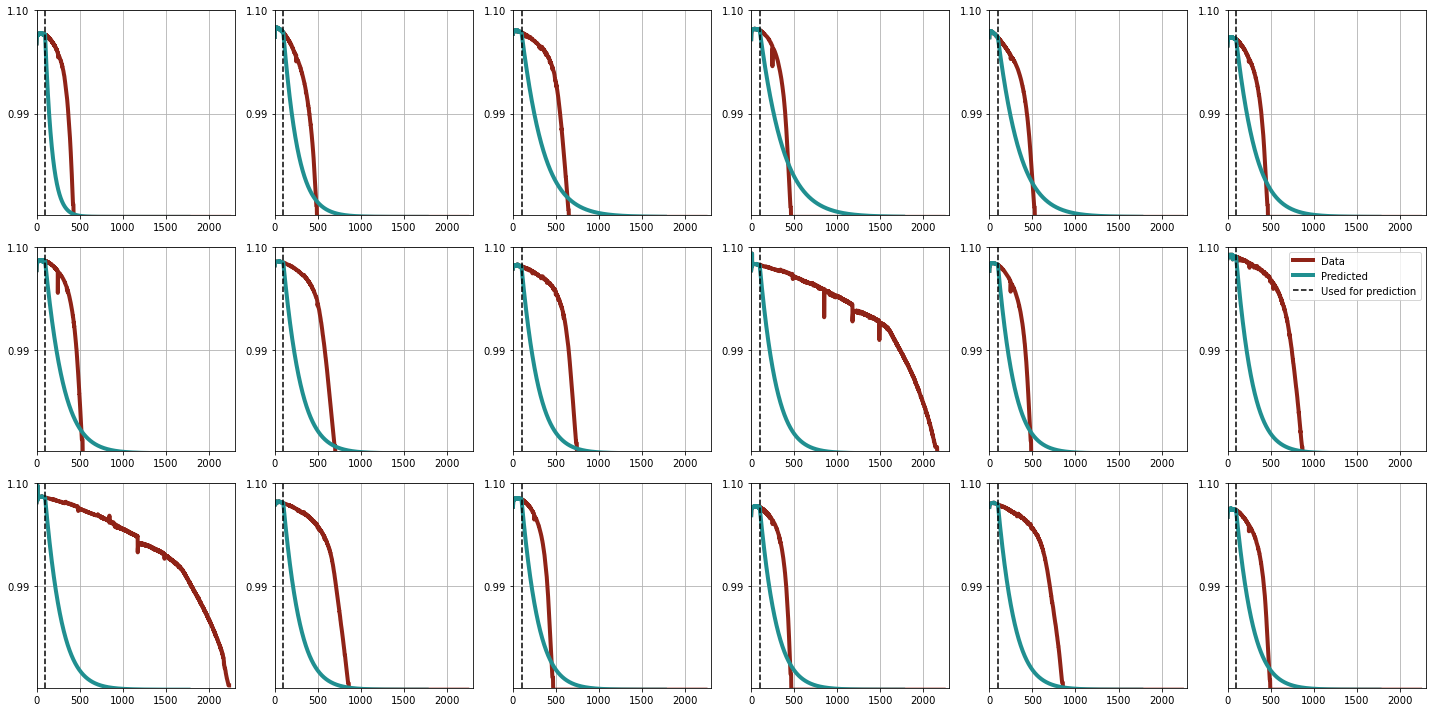

In [19]:
model_idx =0 # results.rmse_state_test.argmax()
fig, axes = plt.subplots(ncols=6, nrows =3, figsize = (20, 10))
linewidth = 4

for i, ax in enumerate(fig.get_axes()):
    if i >= len(used_idxs):
        break
    
    ax.plot(x_preprocessed[used_idxs[i]]* (1.1-.8*1.1) + .8*1.1, c = colours[1], label = 'Data',linewidth = linewidth)

        
    lower_limit = all_lower_quantile[model_idx, i]* (1.1-.8*1.1) + .8*1.1
    upper_limit = all_upper_quantile[model_idx, i]*  (1.1-.8*1.1) + .8*1.1
    ax.fill_between(np.arange(max_used_steps), upper_limit, lower_limit , facecolor=colours[0], alpha=0.2)
    ax.plot(all_outputs[model_idx,i,:,]* (1.1-.8*1.1) + .8*1.1, c= colours[0], label = 'Predicted',linewidth = linewidth)
    ax.set_yticks([.8*1.1,.9*1.1,  1.1])
    
    ax.set_ylim(.8*1.1+.002,1.1)#hide the lines
    if used_idxs[i] > 84:
        ax.plot(x_preprocessed[used_idxs[i]]* (1.1-.8*1.1) + .8*1.1, c = 'r', label = 'Predicted (calendar-aged)',linewidth = linewidth)


    ax.set_xlim(0,2300)# np.maximum(y[used_idxs[i]], (all_outputs[model_idx, i,:] < 1e-3).argmax())+50)
    ax.axvline(x = seq_length , linestyle = "--", c = 'k', label = 'Used for prediction')
axes[-2,-1].legend(loc =1)
plt.tight_layout()

# plt.savefig(oj(fig_path,"NoCovariates{0!s}.pdf".format(seq_length, )) )